In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, roc_curve, recall_score
from math import sqrt, log
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeClassifier
import graphviz

from sklearn.tree import tree, export_graphviz, DecisionTreeClassifier
from sklearn import tree
from matplotlib import pyplot as plt
from IPython.display import Image, display
%matplotlib inline
plt.style.use('ggplot')
SEED = 42

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


# Read Data

In [2]:
link_wave_5 = "../data/raw_datasets/next_steps/wave_5/wave_5.csv"
link_wave_5_family = "../data/raw_datasets/next_steps/wave_5/wave_5_family_background.csv" 
link_wave_6 = "../data/raw_datasets/next_steps/wave_6/Wave_6.csv"
link_wave_7 = "../data/raw_datasets/next_steps/wave_7/wave_7.csv"
link_wave_8 = "../data/raw_datasets/next_steps/wave_8/wave_8.csv"


df_wave_5 = pd.read_csv(link_wave_5)
df_wave_5_family = pd.read_csv(link_wave_5_family)
df_wave_6 = pd.read_csv(link_wave_6, encoding ='latin1')
df_wave_7 = pd.read_csv(link_wave_7, encoding ='latin1')
df_wave_8 = pd.read_csv(link_wave_8, encoding ='latin1')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,2,7,664) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [253]:
#save data in a dictionary
d = {"w5":df_wave_5, "w6f":df_wave_5_family , "w6": df_wave_6, "w7":df_wave_7, "w8": df_wave_8}

In [254]:
#set index to student id (NSID) for all datasets
for i in d.keys():
    d[i] = d[i].set_index("NSID")
    

# Computation of the Y variable

In [2081]:
def compute_y_variable(df):
    
    '''
    Compute the income variable which is the dependent variable here by using columns W8TOTINA to W8TOTINAB.
    Then delete those columns at the end
        @df: dataframe d["w8"]
    '''

    df = d["w8"].copy()
    
    df["income"] = 1
    
    band = ["1", "2", "3", "4"]
    question = ["B", "C", "D", "E"] 
    
    dict_band = {"B1":"less than 25", 
                 "B2":"25 to 90", 
                 "B3":"50 to 90", 
                 "B4":"90 to 140", 
                 "C1":"140 to 240", 
                 "C2":"240 to 300", 
                 "C3":"300 to 350", 
                 "C4":"350 to 400", 
                 "D1":"400 to 500", 
                 "D2":"500 to 600", 
                 "D3":"600 to 700", 
                 "D4":"700 to 800", 
                 "E1":"800 to 900", 
                 "E2":"900 to 1200", 
                 "E3":"1200 to 1400",
                 "E4":"more than 1400"}
    
    #loop through question B to E
    for q in question:
        
        #for each question loop through band 1 to 4 accounting for different range of salaries within each question
        for b in band:

            df["income"][df["W8TOTIN" + q] == "Total income question " + q + " band " + b] = dict_band[q+b]
        
        #drop corresponding column
        #df = df.drop("W8TOTIN" + q, axis = 1)
    #Filter only rows with income different that 1 namely those currently working and for who we know the salary
    df = df[df["income"] != 1]
    
    #drop column of question A of income
    #df = df.drop(["W8TOTINA"], axis = 1)
    
    #only keep the income variable
    df = df[["income"]]
    
    return df


d["w8_income"] = compute_y_variable(d["w8"]) 


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [1386]:
def reduce_n_class_income(df):
    
    '''
    Reduce the number of classes in the y variable income
        @df: dataframe with predictors X and dependent variable y
    '''
    
    df = df.copy()
    
    df[df["income"].isin(["less than 25", "25 to 90", "50 to 90", "90 to 140", "140 to 240"])] = "25 to 240"
    df[df["income"].isin(["300 to 350", "350 to 400"])] = "300 to 400"
    df[df["income"].isin(["400 to 500", "500 to 600"])] = "400 to 600"
    df[df["income"].isin(["600 to 700", "700 to 800", "800 to 900"])] = "600 to 900"
    df[df["income"].isin(["900 to 1200", "1200 to 1400", "more than 1400"])] = "more than 900"
    
    return df

d["w8_income_transformed"] = reduce_n_class_income(d["w8_income"])
    
    
    

# Processing functions

In [1694]:
def filter_over_curr_act(df, l_activity):
    
    '''
    Picks persons whose current activity (W7TCurrentAct) is in the list l_activity
        @df: Wave 7 dataframe
        @l_activity: list including activities that we want to filter
    '''
    
    df_filter_students = df[df["W7TCurrentAct"].isin(l_activity)]
    
    return df_filter_students

df_filter_students = filter_over_curr_act(d["w7"], ["University", "Apprenticeship", "Training course/scheme"])




In [1695]:
def join_X_and_y_vars(X, d, all_classes = True):
    
    '''
    Inner join a dataframe with the income series from wave 8 (d["w8_income"])
        @X: Dataframe containing the predictors X
        @y: Series of the income classes computed from the wave 8 dataframe
    '''
    
    if all_classes == True:
        y = d["w8_income"]
    else:
        y = d["w8_income_transformed"]
    
    df_filter_students_with_income = pd.concat([X, y], axis = 1, join = "inner")
    
    return df_filter_students_with_income


df_filter_students_with_income = join_X_and_y_vars(df_filter_students, d, all_classes = False)



In [1696]:
def pre_processing(df):
    
    '''
    Drops variables that are not relevant in the case of the target pool of persons (here students)
    Example1: Remove variables related to people already working and earning a salary at wave 7
    Example2: Remove variables related to those students still in high school and taking A levels at wave 7
        @df: Dataframes with predictors X and y variables (income) concatenated
    '''
    
    #drop W7_lsype_wt and W7_lsype_wt_skiponly
    df = df.drop(["W7_lsype_wt", "W7_lsype_wt_skiponly"], axis = 1)
    
    #drop variable wheter still doing activity from wave 6 (W7ActStillYP, W7ActContYP, W7StillEdChkYP)
    df = df.drop(["W7ActStillYP", "W7ActContYP"], axis = 1)
    
    #drop variable W7WhetraiYP for Whether know how to go about getting the 
    #qualifications or training needed to get the job they want
    df = df.drop("W7WhetraiYP", axis = 1)
    
    #drop all variables related to those having a job 
    #(all values are not applicable) or NEET or Academic variable 
    #relating to those still in high school or NVQ
    l = []
    for var in df.columns:
    
        if ("Mainmeth" not in var) & ("Career" not in var) & ("JobTyp2" not in var) & ("Leav"not in var) & ("NEET"not in var) & ("Academic" not in var) & ("NVQ" not in var):
        
            l.append(var)
    
    df = df[l]
    
    df = df.drop(["W7JobFYP", "W7JbApplyYP", "W7AskIntYP", "W7JobOffYP", "W7HEApplyYP", "W7finwt"], axis = 1)
    
    return df

df_filter_students_with_income_clean = pre_processing(df_filter_students_with_income)



In [1128]:
#Save df_filter_students_with_income_clean in the dictionary
d["df_filter_students_with_income_clean"] = df_filter_students_with_income_clean

In [1742]:
#save clean dataset
df_filter_students_with_income_clean.to_csv("../data/clean_datasets/next_step_clean_data/clean_data_w8_w7_combined.csv")

# ML functions built

In [1697]:
#convert string variables to categorical then to integers 
def change_cat_to_int(df):
    
    '''
    Encoding method 1
    
    Convert string variables to categorical then to integers (except the y variable) to be used for a decision tree or ramdom forest.
    This is a method used instead of doing one hot encoding
        @df: Dataframes with predictors X 
    '''
    
    df = df.copy()
    temp = df.drop(["income"], axis = 1)
    col_cat = temp.columns
    
    for col in col_cat:
        df[col] = df[col].astype("category").cat.codes
    
    return df
    
df_filter_students_with_income_clean_cat_method = change_cat_to_int(df_filter_students_with_income_clean)
    

In [1698]:
#convert string variables to categorical then to integers 
def encode(df):
    
    '''
    Encoding method 2
    
    Doing 1 hot encoding on the categorical variables (except the y variable)
        @df: Dataframes with predictors X and variable y (incone)
    '''
    
    df = df.copy()
    temp = df.drop(["income"], axis = 1)
    col_cat = temp.columns
    
    df_dummies = pd.get_dummies(df[col_cat])
    
    df = pd.concat([df_dummies, df[["income"]]], axis=1)
    
    return df
    
df_filter_students_with_income_clean_hot_method = encode(df_filter_students_with_income_clean)


In [1120]:
def get_features_importance(model):

    '''
    Show the feature importance from a random forest
        @model: model computer using sklearn
    '''
    
    plt.figure()
    
    features_importance = pd.Series(model.feature_importances_, index = X.columns)

    sorted_importances_rf = features_importance.sort_values()[-10:]
  
    sorted_importances_rf.plot(kind = "barh", color = "purple")
    
    plt.show()
    

In [1519]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [1202]:
def grid_cv_model(model, param_grid, X_train, y_train, X_test, number_cv = 5, print_score_best = True, score = None):
      
    '''
    Compute a grid search cv for a model
    
        @model: Model with the fixed initialized parameters
        @param_grid: grid parameters for the cv model
        X_train: X training data with predictors already encoded
        y_train: y training data 
        X_test: X test data with predictors already encoded
        number_cv: Number of cross folders for each model 
        print_score_best: Boolean see the performance and parameters of the best model
        score: loss function to use in the CV
    '''
    model_cv = GridSearchCV(model, param_grid, cv = number_cv, scoring = score)
    
    model_cv.fit(X_train, y_train)
    
    if print_score_best == True: 
        
        print("Best model is ", model_cv.best_params_)
        print("Best model score is ", model_cv.best_score_)
    
    best_model = model_cv.best_estimator_
    
    return best_model


In [1710]:
#all functions to evaluate a binary model
def plot_confusion_matrix_t(y_true, y_pred,classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    Prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.figure()
    
    
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def get_features_importance(model, X):

    plt.figure()
    
    features_importance = pd.Series(model.feature_importances_, index = X.columns)

    sorted_importances_rf = features_importance.sort_values()[-10:]
  
    sorted_importances_rf.plot(kind = "barh", color = "purple")
    plt.show()
    
def get_roc_curve(model, treshold, X_val_or_test, y_val_or_test):
    
    plt.figure()
    print(treshold)
    y_pred_prob = model.predict_proba(X_val_or_test)[:, 1]
    
    fpr, tpr, tresholds = roc_curve(y_val_or_test, y_pred_prob)
    plt.plot([0, 1], [0, 1], "k--")
    plt.plot(fpr, tpr, label = "random forest")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Random Forest ROC Curve")
    plt.show()
    
def get_classification_table(y_pred, y_val_or_test):
    
    print(classification_report(y_val_or_test, y_pred))
    

def evaluate_model(model, X_train, y_train, X_val_or_test, y_val_or_test, treshold = 0.5, multi_class = True):
    
    '''
    Evalutes a classification model by giving:
    - The confusion matrix
    - The accuracy score
    - The ROC curve
    - The classification table with ratios fron the confusion matrix (recall, precisions etc...)
    - The most important features from the model
    
        @model: Model used
        @X_train: X training data with predictors already encoded
        @X_val_or_test: X test data with predictors already encoded
        @y_train: Series with the predictor variable for the training set containing all classes of income
        @y_test: Series with the predictor variable for the test set containing all classes of income
        @treshold: probability rate at which we decide if an observation takes value 1 or 0
        @multi_class: True if multi class model in y, False if binary classifier
    '''
    
    y_pred_prob = model.predict_proba(X_val_or_test)[:, 1] >= treshold
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    if multi_class == True:
        cm = confusion_matrix(y_val_or_test, y_pred)
        plot_confusion_matrix_t(cm,
                          y_val_or_test.unique())
        print("accuracy_score is ", accuracy_score(y_val_or_test, y_pred))
        
    else:
        plot_confusion_matrix_t(y_val_or_test, y_pred_prob, classes= np.array([0, 1]),
                      title='confusion matrix')
        get_roc_curve(model, treshold, X_val_or_test, y_val_or_test)
    
        get_classification_table(y_pred_prob, y_val_or_test)
        
        print("recall on test set is ", recall_score(y_val_or_test, y_pred))
        print("recall on training set is ", recall_score(y_train, y_pred_train))
    
    get_features_importance(model, X_test)
    
    
    
    


# Training/test split

In [1699]:
def train_test_split_method(df_filter_students_with_income_clean_hot_method, df_filter_students_with_income_clean_cat_method, hot = True):

    '''
    Divides data into training and test set depending of the method of encoding
    
        @df_filter_students_with_income_clean_hot_method: Dataframe encoded with one hot encoding
        @df_filter_students_with_income_clean_cat_method: Dataframe encoded with cat encoding
        @hot: Boolean if hot encoding is used
    '''
    
    if hot == True:
        X = df_filter_students_with_income_clean_hot_method.drop("income", axis = 1)
        y = df_filter_students_with_income_clean_hot_method["income"]
    else:
        X = df_filter_students_with_income_clean_cat_method.drop("income", axis = 1)
        y = df_filter_students_with_income_clean_cat_method["income"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = SEED, stratify = y)
    
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = train_test_split_method(df_filter_students_with_income_clean_hot_method, 
                                                           df_filter_students_with_income_clean_cat_method, 
                                                           hot = True)


# Random Forest 

In [1531]:
#with class weights
param_grid = {'n_estimators': [500],  
              "max_depth":[5, 10, 20, 30, 50], 
              "min_samples_leaf":[100, 50, 40, 30, 20, 10, 5],
              "max_features":[round(sqrt(X.shape[1])), round(log(X.shape[1])/log(2))]}

rf = RandomForestClassifier(random_state = SEED)

model_rf = grid_cv_model(rf, param_grid, X_train, y_train, X_test)

Best model is  {'max_depth': 20, 'max_features': 40, 'min_samples_leaf': 10, 'n_estimators': 500}
Best model score is  0.2888303226632991


[[ 5 18  0 39  2  0]
 [ 3 19  0 49  2  0]
 [ 2 13  2 46  5  0]
 [ 8 15  2 74  9  0]
 [ 4  4  0 50 14  0]
 [ 1  0  0 20  7  0]]
0.27602905569007263


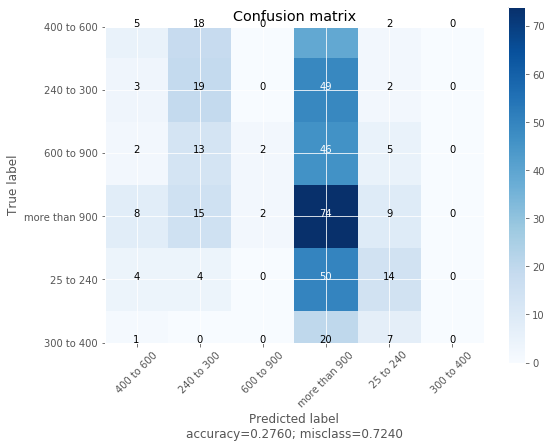

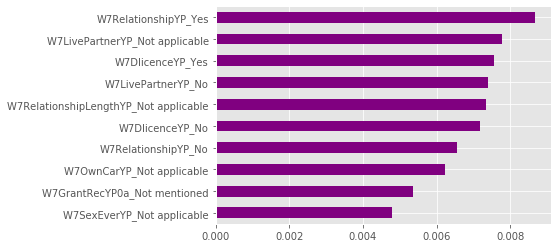

1.9642857142857142


In [1532]:
cm = confusion_matrix(y_test, model_rf.predict(X_test))
print(cm)
print(accuracy_score(y_test, model_rf.predict(X_test)))
evaluate_model(model_rf, X_test, y_test,multi_class = True)
score_missclassified_mean, l_missclassified = difference_metrics(dict_diff, y_test, y_pred_multi)
print(score_missclassified_mean)

# Ridge

In [1071]:
param_grid_ridge = {'alpha': [20, 30, 40, 50, 60]}

ridge = RidgeClassifier()

ridge_cv = GridSearchCV(ridge, param_grid_ridge, cv = 5)

ridge_cv.fit(X_train, y_train)

print(ridge_cv.best_params_)
print(ridge_cv.best_score_)

best_model_ridge = ridge_cv.best_estimator_

y_pred_ridge = best_model_ridge.predict(X_test)

accuracy_score(y_test, y_pred_ridge)


{'alpha': 40}
0.1681610205164809


0.14285714285714285

# Decision tree 

In [1722]:
clf = DecisionTreeClassifier(min_samples_split=200, random_state = SEED)

# Build classification tree
# Build classification tree
tree_est = clf.fit(X_train, y_train)

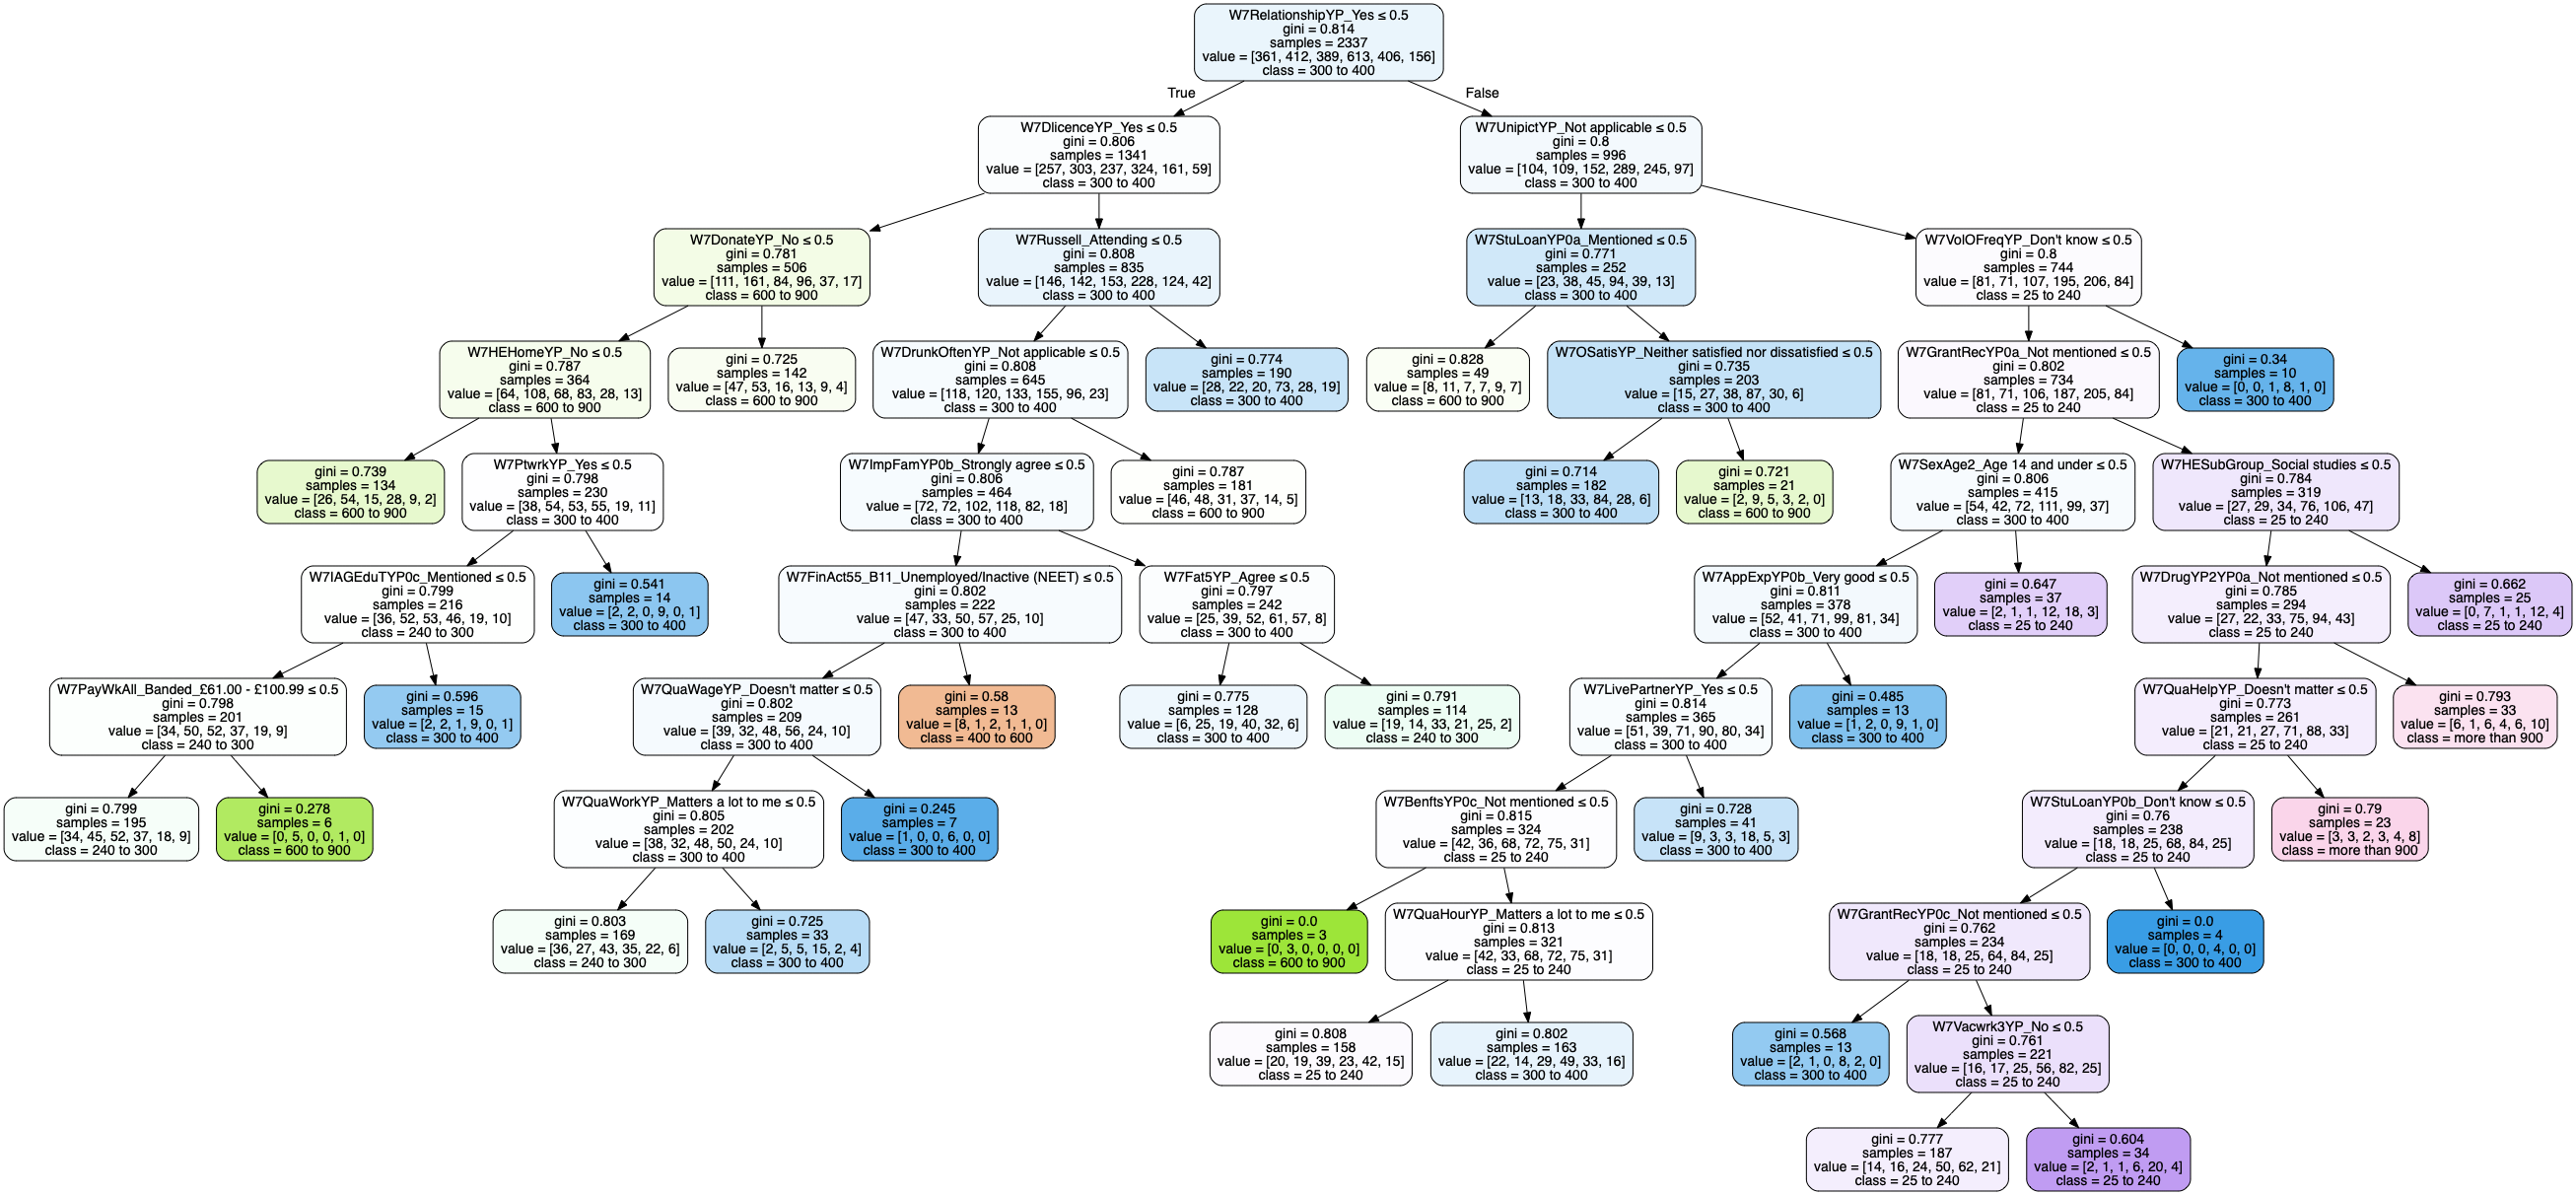

In [1723]:
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
predictors = X_train.columns.tolist()

dot_data = export_graphviz(tree_est, out_file='seat_tree.dot',feature_names=predictors, 
                class_names=y_train.unique(),filled=True, rounded=True,  
                        special_characters=True)

with open('seat_tree.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

In [1727]:
df_filter_students_with_income_clean["W7HEelseYP"].value_counts()

Not applicable       2064
Disagree              294
Strongly disagree     244
Agree                 117
Strongly agree         20
Don't know             11
Name: W7HEelseYP, dtype: int64

In [ ]:
df_filter_students_with_income_clean

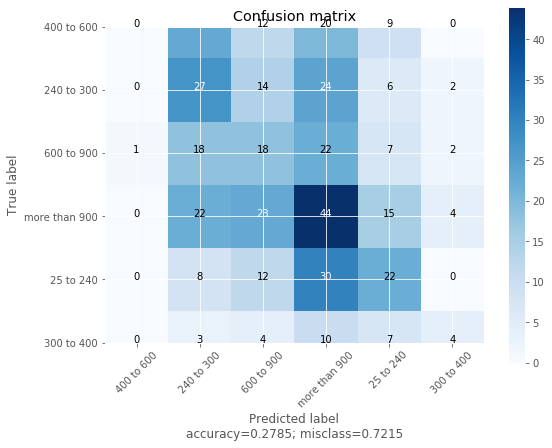

accuracy_score is  0.2784503631961259


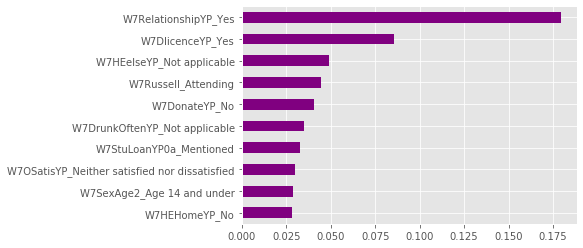

In [1721]:
#y_pred = clf.predict(X_test)
evaluate_model(clf, X_train, y_train, X_test, y_test)        

# Better model with a dataframe for each class in the y variable

In [1729]:
def build_df_for_each_class(y):
    
    '''
    Creates a dictionanry with an entry for each class in y and gives 1 if the value of y is equal to the 
    corresponding class and 0 otherwise
        @y: Series corresponding to the dependent variable
    '''
    
    dict_classes = {}
    
    for cl in df_filter_students_with_income_clean["income"].unique():
        
        y_temp = y.copy()
        y_temp[y_temp != cl] = 0
        y_temp[y_temp == cl] = 1
        
        y_temp = y_temp.astype("int")
        dict_classes[cl] = y_temp
        
    return dict_classes

dict_classes_train = build_df_for_each_class(y_train)
dict_classes_test = build_df_for_each_class(y_test)

Confusion matrix, without normalization
[[333   7]
 [ 69   4]]
0.5


<Figure size 432x288 with 0 Axes>

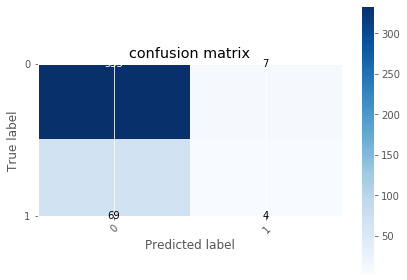

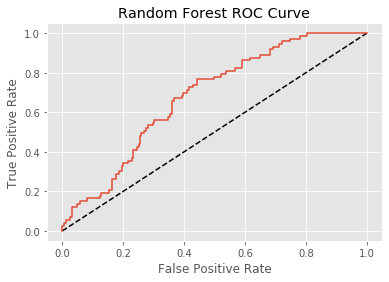

              precision    recall  f1-score   support

           0       0.83      0.98      0.90       340
           1       0.36      0.05      0.10        73

    accuracy                           0.82       413
   macro avg       0.60      0.52      0.50       413
weighted avg       0.75      0.82      0.76       413

recall on test set is  0.0547945205479452
recall on training set is  0.24029126213592233


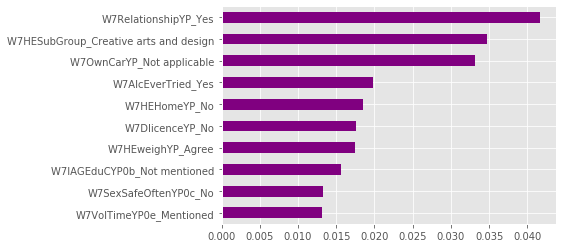

None
Confusion matrix, without normalization
[[347   2]
 [ 61   3]]
0.5


<Figure size 432x288 with 0 Axes>

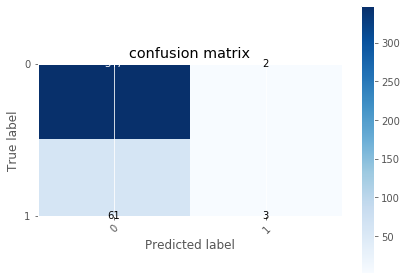

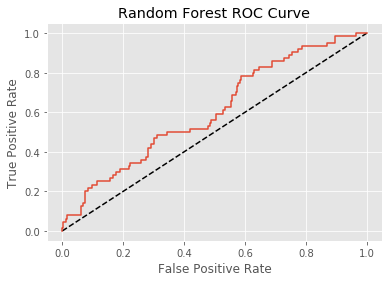

              precision    recall  f1-score   support

           0       0.85      0.99      0.92       349
           1       0.60      0.05      0.09        64

    accuracy                           0.85       413
   macro avg       0.73      0.52      0.50       413
weighted avg       0.81      0.85      0.79       413

recall on test set is  0.046875
recall on training set is  0.2077562326869806


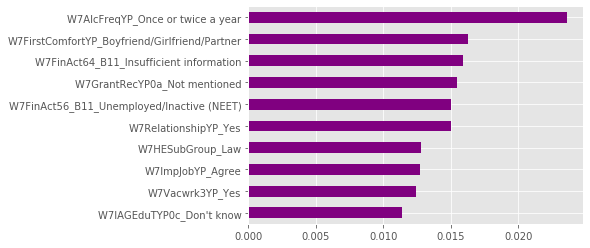

None
Confusion matrix, without normalization
[[341   4]
 [ 68   0]]
0.5


<Figure size 432x288 with 0 Axes>

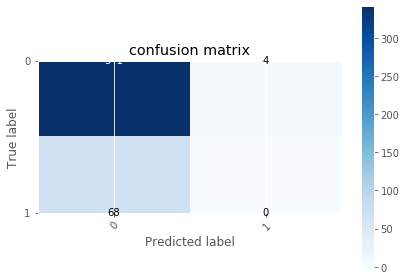

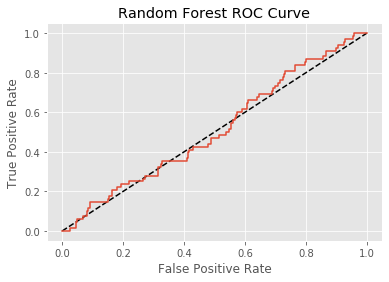

              precision    recall  f1-score   support

           0       0.83      0.99      0.90       345
           1       0.00      0.00      0.00        68

    accuracy                           0.83       413
   macro avg       0.42      0.49      0.45       413
weighted avg       0.70      0.83      0.76       413

recall on test set is  0.0
recall on training set is  0.12082262210796915


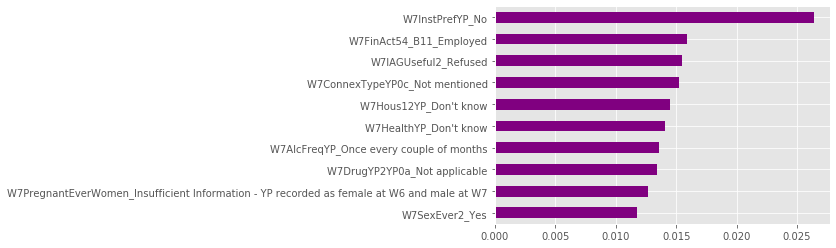

None
Confusion matrix, without normalization
[[300   5]
 [104   4]]
0.5


<Figure size 432x288 with 0 Axes>

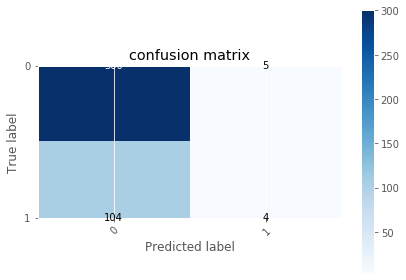

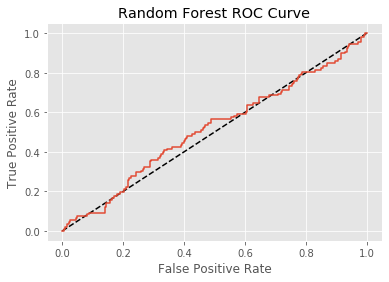

              precision    recall  f1-score   support

           0       0.74      0.98      0.85       305
           1       0.44      0.04      0.07       108

    accuracy                           0.74       413
   macro avg       0.59      0.51      0.46       413
weighted avg       0.66      0.74      0.64       413

recall on test set is  0.037037037037037035
recall on training set is  0.17455138662316477


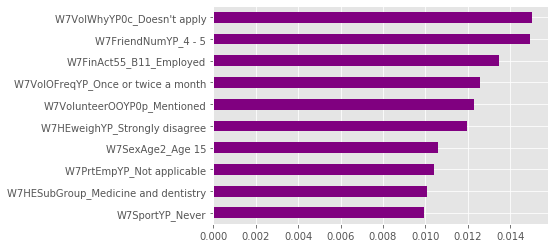

None
Confusion matrix, without normalization
[[338   3]
 [ 68   4]]
0.5


<Figure size 432x288 with 0 Axes>

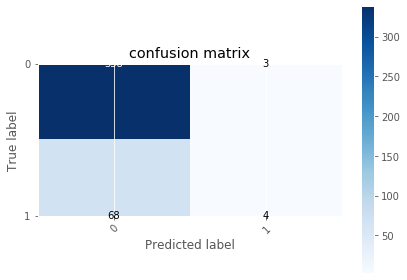

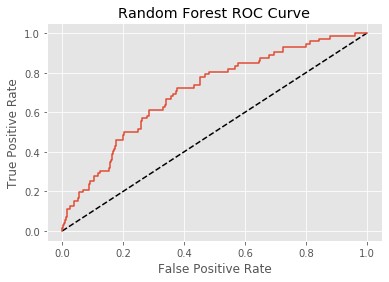

              precision    recall  f1-score   support

           0       0.83      0.99      0.90       341
           1       0.57      0.06      0.10        72

    accuracy                           0.83       413
   macro avg       0.70      0.52      0.50       413
weighted avg       0.79      0.83      0.76       413

recall on test set is  0.05555555555555555
recall on training set is  0.21428571428571427


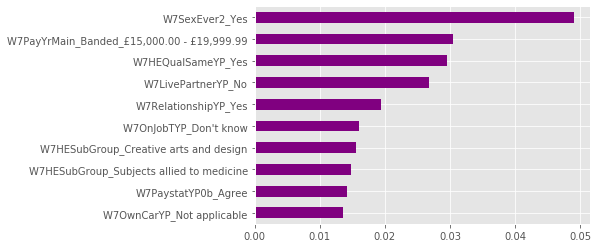

None
Confusion matrix, without normalization
[[385   0]
 [ 28   0]]
0.5


<Figure size 432x288 with 0 Axes>

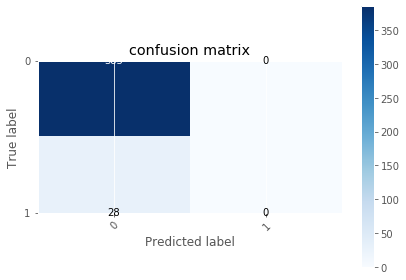

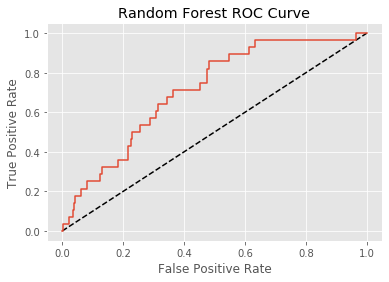

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       385
           1       0.00      0.00      0.00        28

    accuracy                           0.93       413
   macro avg       0.47      0.50      0.48       413
weighted avg       0.87      0.93      0.90       413

recall on test set is  0.0
recall on training set is  0.2692307692307692


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


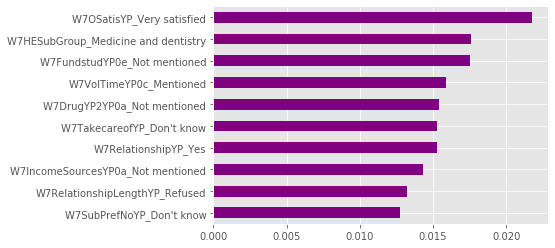

None


In [1730]:
def compute_model_for_each_class(X_train, X_test, dict_classes_train, dict_classes_test):
    
    '''
    Builds a binary classifier model for each entry of the dictionary and evaluates the model 
    
        @X_train: X training data with predictors already encoded
        @X_test: X test data with predictors already encoded
        @dict_classes_train: Contains the binary y train series for each entry of the dictionary
        @dict_classes_test: Contains the binary y test series for each entry of the dictionary
    '''
    
    l_class = ["25 to 240", "240 to 300", "300 to 400", "400 to 600", "600 to 900", "more than 900"]
    dict_models = {}
    
    #loop in the right order where each entry of l_class is associated with a model
    for cl in l_class:
        
     
        dict_models[cl] = GradientBoostingClassifier(random_state = SEED)
                                                                                  
        dict_models[cl].fit(X_train, dict_classes_train[cl])
        print(evaluate_model(dict_models[cl], X_train, dict_classes_train[cl], X_test, dict_classes_test[cl], multi_class = False))
        
    return dict_models

dict_models = compute_model_for_each_class(X_train, X_test, dict_classes_train, dict_classes_test)

In [1689]:
#class 1: less than 25 to 140 (5): 411 data 
#class 2: 240 to 300: 361 data
#class 3: 300 to 400 (2): 388 data 
#class 4: 400 to 600 (2): 613
#class 5: 600 to 900 (3): 407
#class 6: More than 900 (3): 157

In [1731]:
def build_needed_data_structure(dict_models):
    
    '''
    build index a list going from 0 to number of models (so number of classes)
    build dict_y a dictionary with the index in keys and the different classes as values (to be used to make prediction)
    build dict_diff the inverse of dict_y for keys and values (to be used in the different metrics function)
     
        @dict_models: Dictionary where each key is a class value from income and values is the associated model 
    '''
    
    index = range(len(dict_models))
    dict_y = dict(zip(index, dict_models.keys()))
    l_models = list(dict_models.values())
    dict_diff = {v: k for k, v in dict_y.items()}
    
    return dict_y, l_models, dict_diff

dict_y, l_models, dict_diff = build_needed_data_structure(dict_models)
    

In [1732]:
def get_prediction_matrix(l_models, X_test):
    
    '''
    Computes a prediction matrix where each row is an observation and each coluum corresponds to the probabiliy 
    of getting the class associated with the corresponding model number (column 1 for model 1  and column p 
    for model p) 
    
        @l_models: A list of all different models for each class 
    '''
    
    for index in range(len(l_models)):

        if index == 0:

            pred_0 = l_models[0].predict_proba(X_test)[:,1]
            pred_1 = l_models[1].predict_proba(X_test)[:,1]

            pred_0 = pred_0.reshape((len(pred_0), 1))
            pred_1 = pred_1.reshape((len(pred_1), 1))

            m = np.concatenate((pred_0, pred_1), axis = 1)
        
        else:
            try:
                pred_i = l_models[index+1].predict_proba(X_test)[:,1]

                pred_i = pred_i.reshape((len(pred_i), 1))

                m = np.concatenate((m, pred_i), axis = 1)
            except:
                break
    
    return m
    

In [1733]:
def multi_model_predict(l_models, X_test, dict_y):
    
    '''
    Associate a given observation to a class (predicts) by associating this observation to the model that 
    maximises the proability of this class model (so if probability is maximised on column j, then predicts the class
    associated with model j)
    
        @l_models: A list of all different models for each class 
        @dict_y: A dictionary with the index in keys and the different classes as values (to be used to make prediction)
    '''
    
    matrix_pred = get_prediction_matrix(l_models, X_test)
    y_pred = []
    for i in np.argmax(matrix_pred, axis = 1):
        y_pred.append(dict_y[i])
    
    return y_pred

y_pred_multi = multi_model_predict(l_models, X_test, dict_y)

In [1737]:
def difference_metrics(dict_diff, y_test, y_pred):
    
    '''
    The difference metrics computes how far a preciction is from its actual value by calculating how many classes away
    the prediction is from the true value (example if predicts 300-350 and the actual value is in the next category
    350-400, then computes a difference metrics of 1)
        
        @dict_diff: The inverse of dict_y for keys and values (to be used in the different metrics function)
        @y_test: Series with the predictor variable for the test set containing all classes of income
        @y_pred: Series with the predictor variable for the training set containing all classes of income
    '''
    
    l_missclassified = []
    score_missclassified_total = 0
    number_missclassified = (y_test != y_pred).sum()
    #select only y points which were incorrectly predicted
    y_test_missclassified = y_test[y_test != y_pred]
    #select only y pred points whose predictions were incorrect
    y_pred_missclassified = [y_pred[i] for i in range(len(y_pred)) if (y_test[i] != y_pred[i])]
    
    for i in range(y_test_missclassified.size):
        
        diff_missclassified = abs(dict_diff[y_test_missclassified[i]] - dict_diff[y_pred_missclassified[i]])
        l_missclassified.append(diff_missclassified)
        score_missclassified_total += diff_missclassified
    
    score_missclassified_mean = score_missclassified_total/y_test_missclassified.size
    
    return score_missclassified_mean, l_missclassified
        
score_missclassified_mean, l_missclassified = difference_metrics(dict_diff, y_test, y_pred_multi)

score_missclassified_mean

1.8070175438596492

In [1738]:
accuracy_score(y_test, y_pred_multi)

0.3099273607748184

# Default rate Processing

In [1750]:
import string

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [1753]:
l = []
for i in string.ascii_uppercase:
    
    l.append("W8DEBT10" + i)
    
    if i == "I":
        break
l

['W8DEBT10A',
 'W8DEBT10B',
 'W8DEBT10C',
 'W8DEBT10D',
 'W8DEBT10E',
 'W8DEBT10F',
 'W8DEBT10G',
 'W8DEBT10H',
 'W8DEBT10I']

In [1758]:
temp = d["w8"][l]

In [1765]:
(temp == "No").T.all().sum()

3453

In [1954]:
d["w8"][["W8MMOP", "W8QDEB2"]]

,W8MMOP,W8QDEB2
NSID,,
NS10001S,Not applicable,7000
NS10004W,395,10000
NS10011M,631,1000
NS10020F,Not applicable,Not applicable
NS10021G,Not applicable,2700
...,...,...
NS26114B,Not applicable,4000
NS26117E,885,7000
NS26118F,Not applicable,Not applicable


In [1823]:
def convert_string_to_int(df):
    
    df = df.copy()
    
    for col in df.columns:
        
        temp_col = pd.to_numeric(df[col], errors = "coerce")
        
        temp_col[temp_col.isnull()] = df[col][temp_col.isnull()]
        
        df[col] = temp_col
        
    return df

df = convert_string_to_int(d["w8"])

In [1824]:
def remove_date_variables(df):
    
    df = df.drop(["W8INTYEAR", 
             "W8BDATY", 
             "W8BDATY", 
             "W8NRDOBY", 
             "W8NRLIVEY", 
             "W8MOVINY2", 
             "W8STARTY", 
             "W8LASTEMPYEAR"], axis = 1)
    
    return df

df = remove_date_variables(df)  
    

In [1834]:
def process_y_variable(df, var):
    
    df = df[(df[var] != "Not applicable") & (df[var] != "Refused") & (df[var] != "Don't know")]
    
    return df

df_filtered = process_y_variable(df, "W8QPAYMAKE")



In [2063]:
#identify numerical columns
def identify_num_col(df):
    
    l_num_col = []
    
    for i in df.index[:100]:
        
        for col in df.columns:
            
            if type(df.loc[i, col]) == float:
                
                if col not in l_num_col:
                    
                    l_num_col.append(col)
        
    return l_num_col

l_t = identify_num_col(df_filtered)

In [1849]:
df_filtered_num = df_filtered[l_t]

In [1871]:
d["w8_income"][["income", 
                "W8GROA", 
                "W8GROW", 
                "W8NETA", 
                "W8NETW", 
                "W8NEGRCK", 
                "W8USLA", 
                "W8USLW", 
                "W8SEPA", 
                "W8SJUA"]]



,income,W8GROA,W8GROW,W8NETA,W8NETW,W8NEGRCK,W8USLA,W8USLW,W8SEPA,W8SJUA
NSID,,,,,,,,,,
NS10001S,500 to 600,490,490,405,405,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable
NS10004W,800 to 900,1450,334.87,1200,277.14,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable
NS10011M,600 to 700,2500,577.37,3590,829.1,"Yes, these amounts are correct",1800,415,Not applicable,Not applicable
NS10020F,240 to 300,828,191.22,809,186.84,Not applicable,Don't know,Not applicable,Not applicable,Not applicable
NS10021G,240 to 300,1706,394,1424,328.87,Not applicable,1276,294,Not applicable,Not applicable
...,...,...,...,...,...,...,...,...,...,...
NS26114B,600 to 700,500,500,378,378,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable
NS26117E,800 to 900,31000,596.15,1950,450.35,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable
NS26118F,240 to 300,1123,374.33,971,323.67,Not applicable,1200,277,Not applicable,Not applicable


In [2079]:
def replace_non_by_mean(df, col):
    
    df = df.copy()
    
    non = ["Don't know", "Not applicable", "Refused"]
    
    df[col][df[col].isin(non)] = round(df[col][np.logical_not(df[col].isin(non))].mean(), 2)
    
    return df
        
t = replace_non_by_mean(df_filtered, "W8HTFEET")      
     

def drop_quant_var(df):
    
    df = df.copy()
    
    #Variables removes because has too many missing values 
    df = df.drop(["W8RELSAT1",
                  "W8RENT", 
                  "W8RENTDV", 
                  "W8PARMA", 
                  "W8PARSA", 
                  "W8JOBDOSOCCODE", 
                  "W8MAKESICCODE", 
                  "W8WRKHRS", 
                  "W8GROW", 
                  "W8GROA", 
                  "W8NETA", 
                  "W8NETW", 
                  "W8PUSA", 
                  "W8TRUST", 
                  "W8RISK", 
                  "W8PATIENCE", 
                  "W8MMOP", 
                  "W8USLA", 
                  "W8AMOUNT", 
                  "W8USLW", 
                  "W8WTKILOS", 
                  "W8REGR", 
                  "W8REGRDV", 
                  "W8DOHMANY", 
                  "W8SEPA", 
                  "W8HOWK", 
                  "W8EASE", 
                  "W8CRWHENMAY", 
                  "W8HOSJ", 
                  "W8SJUA", 
                  "W8REGA", 
                  "W8NRAGE", 
                  "W8JDOPSOCCODE"], axis = 1)
    
    
    
    #W8MCHMANY for number of children, change not applicable to 0
    df[df["W8MCHMANY"] == "Not applicable"] = 0
    
    
    #replace by mean
    l_numerical_var_replace_cate_stuff = ["W8NUMROOMS", 
                                          "W8QDEB2", 
                                          "W8HTFEET", 
                                          "W8HTINCHES", 
                                          "W8WTSTONE", 
                                          "W8WTPOUNDS", 
                                          "W8WEIGHT", 
                                          "W8EXERCISE", 
                                          "W8SLEEP2", 
                                          "W8NUMADMN", 
                                          "W8SOCIALMED", 
                                          "W8HTMETRES", 
                                          "W8HEIGHT"]
                                         
    
    for var in l_numerical_var_replace_cate_stuff:
        
        df = replace_non_by_mean(df, var)

    
    return df    

df_clean = drop_quant_var(df_filtered)  


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
